In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class MorphNet(nn.Module):
    def __init__(self, input_size, hidden_size, dense_dim, output_dim, dropout_prob):
        super(MorphNet, self).__init__()
        self.input_size = input_size
        self.output_dim = output_dim

        self.batch_norm1 = nn.BatchNorm1d(1)



        self.conv1 = nn.Conv1d(in_channels = 1, out_channels=16, kernel_size = 200, stride=1, padding="same")
        self.conv2 = nn.Conv1d(in_channels = 16, out_channels=32, kernel_size = 100, stride=1, padding="same")


        self.pool = nn.MaxPool1d(kernel_size = 2, stride = 2)

        self.fc_size = 4800
        self.fc1 = nn.Linear(self.fc_size, 1200)
        self.fc2 = nn.Linear(1200, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):


        x = self.batch_norm1(x)
        x = self.pool(F.relu(self.conv1(x)))

        x = self.pool(F.relu(self.conv2(x)))


        x = torch.flatten(x, start_dim=1)

        x = self.dropout(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x
  




In [3]:
apnea = pd.read_csv("apnea_ecg_600/combined_apnea.csv") 
#apnea["apnea"].value_counts()
#to_keep = 9941 * 9
#to_keep
#sampled_0s = apnea[apnea.iloc[:, -1] == 0].sample(n=int(to_keep))
#final_df = pd.concat([sampled_0s, apnea[apnea.iloc[:, -1] == 1]])
#apnea = final_df
#apnea["apnea"].value_counts()
apnea["apnea"].value_counts()

apnea
False    2281
True     1470
Name: count, dtype: int64

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = apnea.iloc[:, :-1].values
y = apnea.iloc[:, -1].values
    
X_normalized = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size = 0.2, random_state = 43)
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

X_train = torch.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = torch.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))            
y_train = torch.reshape(y_train, (y_train.shape[0], 1))
y_test = torch.reshape(y_test, (y_test.shape[0], 1))

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

trainloader = DataLoader(train_dataset, batch_size = 32, drop_last=True, shuffle = True)
testloader = DataLoader(test_dataset, batch_size = 128, shuffle = False)

In [5]:
model = MorphNet(input_size = 1, hidden_size = 5, dense_dim = 5, output_dim = 1, dropout_prob = 0.0)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.000005, weight_decay=0.0001)

/home/peter/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


MorphNet(
  (batch_norm1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv1d(1, 16, kernel_size=(200,), stride=(1,), padding=same)
  (conv2): Conv1d(16, 32, kernel_size=(100,), stride=(1,), padding=same)
  (conv3): Conv1d(16, 32, kernel_size=(50,), stride=(1,), padding=same)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4800, out_features=1200, bias=True)
  (fc2): Linear(in_features=1200, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear1): Linear(in_features=264, out_features=1, bias=True)
  (linear2): Linear(in_features=64, out_features=1, bias=True)
  (transformer_encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out

In [6]:
num_epochs = 25
losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model.to(device)
#X_train = X_train.to(device)
#y_train = y_train.to(device)
X_train_mod = X_train.squeeze(2)
X_train_mod = X_train_mod.unsqueeze(1)
#X_train = X_train.unsqueeze(1)
for i in range(num_epochs):
    model.train()
    for input, label in trainloader:
        #print(X_train_mod.shape)
        #print(X_train.shape)
        optimizer.zero_grad()
        
        minput = input.squeeze(2)
        minput = minput.unsqueeze(1)
        y_pred = model.forward(minput)
        #print(y_train)
        #y_pred = y_pred.squeeze(1)
        loss = criterion(y_pred, label)
        losses.append(loss)
        #if i % 10 == 0:
        loss.backward()
        optimizer.step()
        
    model.eval()
    X_test_mod = X_test.squeeze(2)
    X_test_mod = X_test_mod.unsqueeze(1)

    with torch.no_grad():
        # Predict on testing data
        y_pred_test = model.forward(X_test_mod)
        loss_test = criterion(y_pred_test, y_test)
        #print(y_pred_test)
    
        y_pred_test_prob = torch.sigmoid(y_pred_test)
        
    
        y_pred_test_binary = (y_pred_test_prob > 0.5).float()
        
        # Calculate the accuracy
        correct_predictions = (y_pred_test_binary == y_test).float().sum()
        accuracy = correct_predictions / y_test.shape[0]
        
        #print(f'Accuracy: {accuracy.item():.4f}')
    
        y_pred_test_np = y_pred_test_binary.cpu().numpy()
        y_test_np = y_test.cpu().numpy()
        
        # Generate the confusion matrix
        cm = confusion_matrix(y_test_np, y_pred_test_np)
        TN = cm[0,0]
        FN = cm[1,0]
        TP = cm[1,1]
        FP = cm[0,1]
        
    print(f'{int(i / num_epochs * 100)} % done, e: {i} l: {loss.item():10.4f}, val loss: {loss_test}, TPR: {TP / (TP + FN)}, TNR: {TN / (TN + FP)} ' )


/home/peter/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1040.)
  return F.conv1d(input, weight, bias, self.stride,


0 % done, e: 0 l:     0.5830, val loss: 0.3145371675491333, TPR: 0.9444444444444444, TNR: 0.9287257019438445 
4 % done, e: 1 l:     0.2140, val loss: 0.16279639303684235, TPR: 0.9444444444444444, TNR: 0.9352051835853131 
8 % done, e: 2 l:     0.1162, val loss: 0.1457670032978058, TPR: 0.9513888888888888, TNR: 0.9352051835853131 
12 % done, e: 3 l:     0.1620, val loss: 0.13987880945205688, TPR: 0.9548611111111112, TNR: 0.9265658747300216 
16 % done, e: 4 l:     0.1214, val loss: 0.12824496626853943, TPR: 0.9548611111111112, TNR: 0.9460043196544277 
20 % done, e: 5 l:     0.0877, val loss: 0.1281411200761795, TPR: 0.9618055555555556, TNR: 0.9352051835853131 
24 % done, e: 6 l:     0.2088, val loss: 0.13221237063407898, TPR: 0.9652777777777778, TNR: 0.9157667386609071 
28 % done, e: 7 l:     0.1082, val loss: 0.11994495987892151, TPR: 0.9618055555555556, TNR: 0.9438444924406048 
32 % done, e: 8 l:     0.1073, val loss: 0.12420631945133209, TPR: 0.9652777777777778, TNR: 0.9330453563714903

Accuracy: 0.9747
[[454   9]
 [ 10 278]]
Precision: 0.980561555075594
Recall: 0.978448275862069
f1: 0.9795037756202805


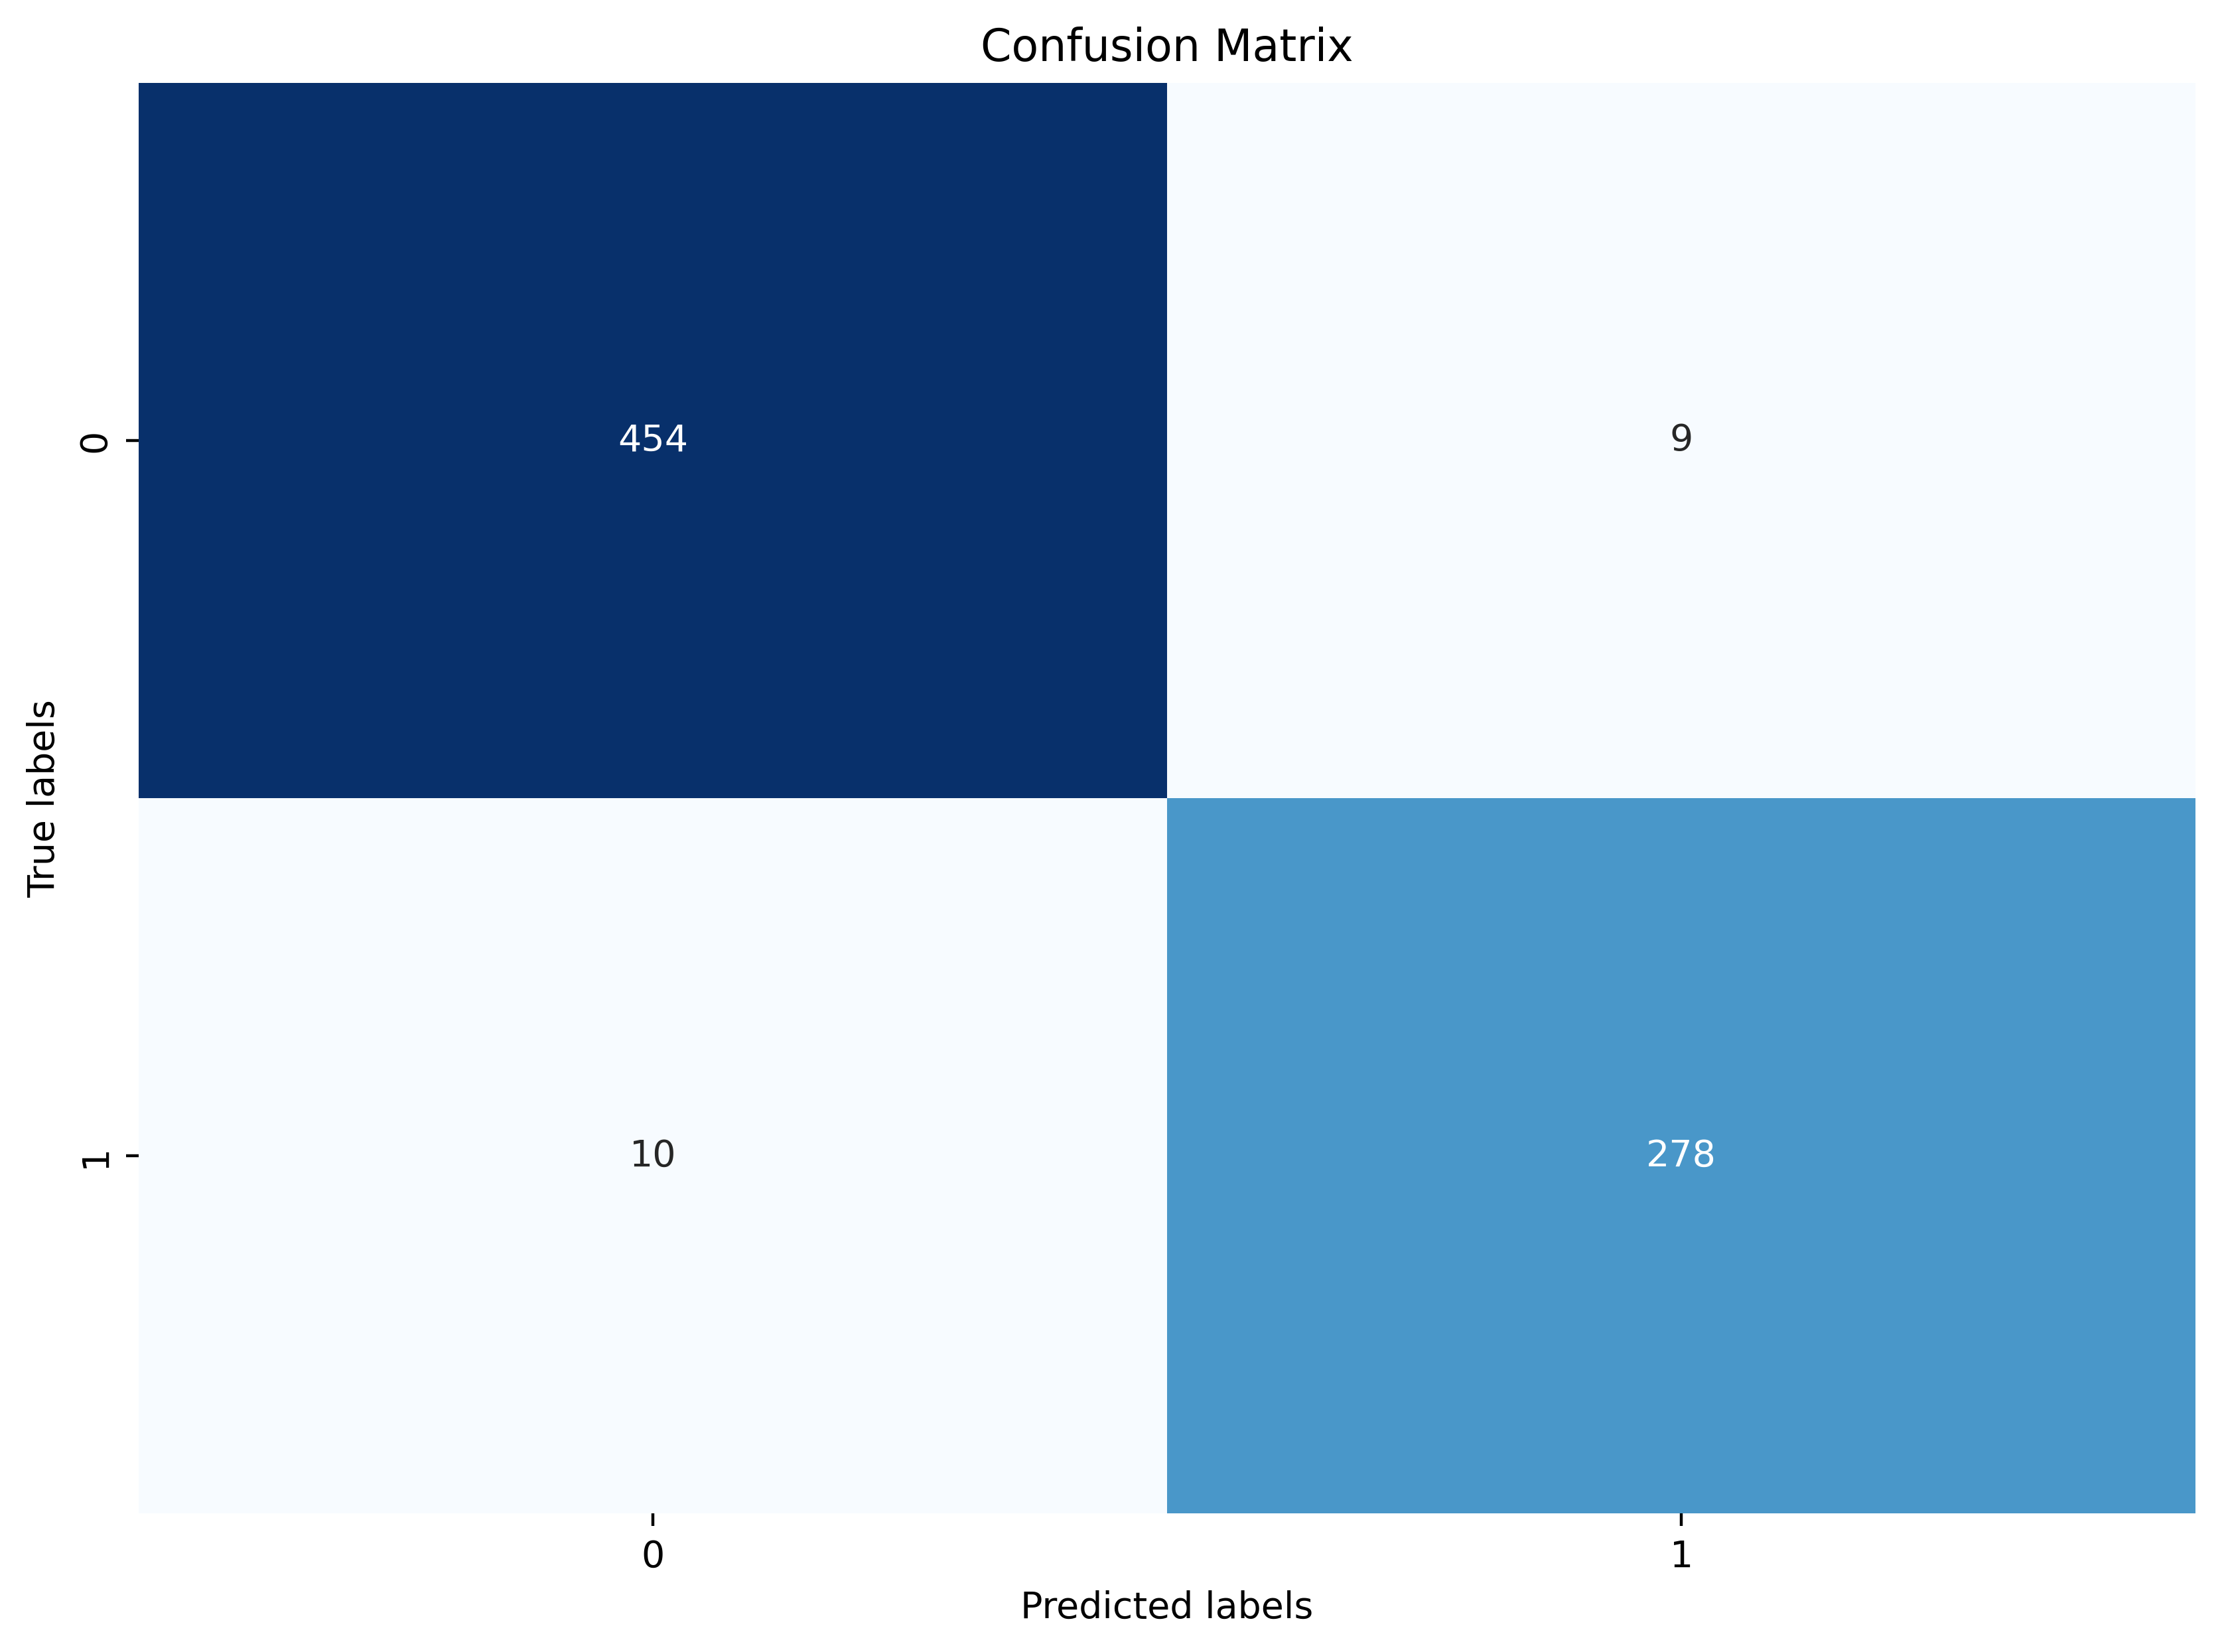

In [7]:
import seaborn as sns
model.eval()

X_test_mod = X_test.squeeze(2)
X_test_mod = X_test_mod.unsqueeze(1)

with torch.no_grad():
    # Predict on testing data
    y_pred_test = model.forward(X_test_mod)
    #print(y_pred_test)

    y_pred_test_prob = torch.sigmoid(y_pred_test)
    

    y_pred_test_binary = (y_pred_test_prob > 0.5).float()
    
    # Calculate the accuracy
    correct_predictions = (y_pred_test_binary == y_test).float().sum()
    accuracy = correct_predictions / y_test.shape[0]
    
    print(f'Accuracy: {accuracy.item():.4f}')

    y_pred_test_np = y_pred_test_binary.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    
    # Generate the confusion matrix
    cm = confusion_matrix(y_test_np, y_pred_test_np)
    print(cm)
    precision = cm[0, 0] / (cm[0, 0] + cm[0,1])
    recall = cm[0, 0] / (cm[0, 0] + cm[1,0])
    f1 = 2 * (precision * recall)/(precision + recall)
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"f1: {f1}")
    plt.figure(figsize=(10,7), dpi=400)  # You can adjust the size as needed
    sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", cbar=False)  # 'g' means generic number format
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.savefig('morph_cf.png')
        

In [8]:
torch.save(model, "apneaecg_model")

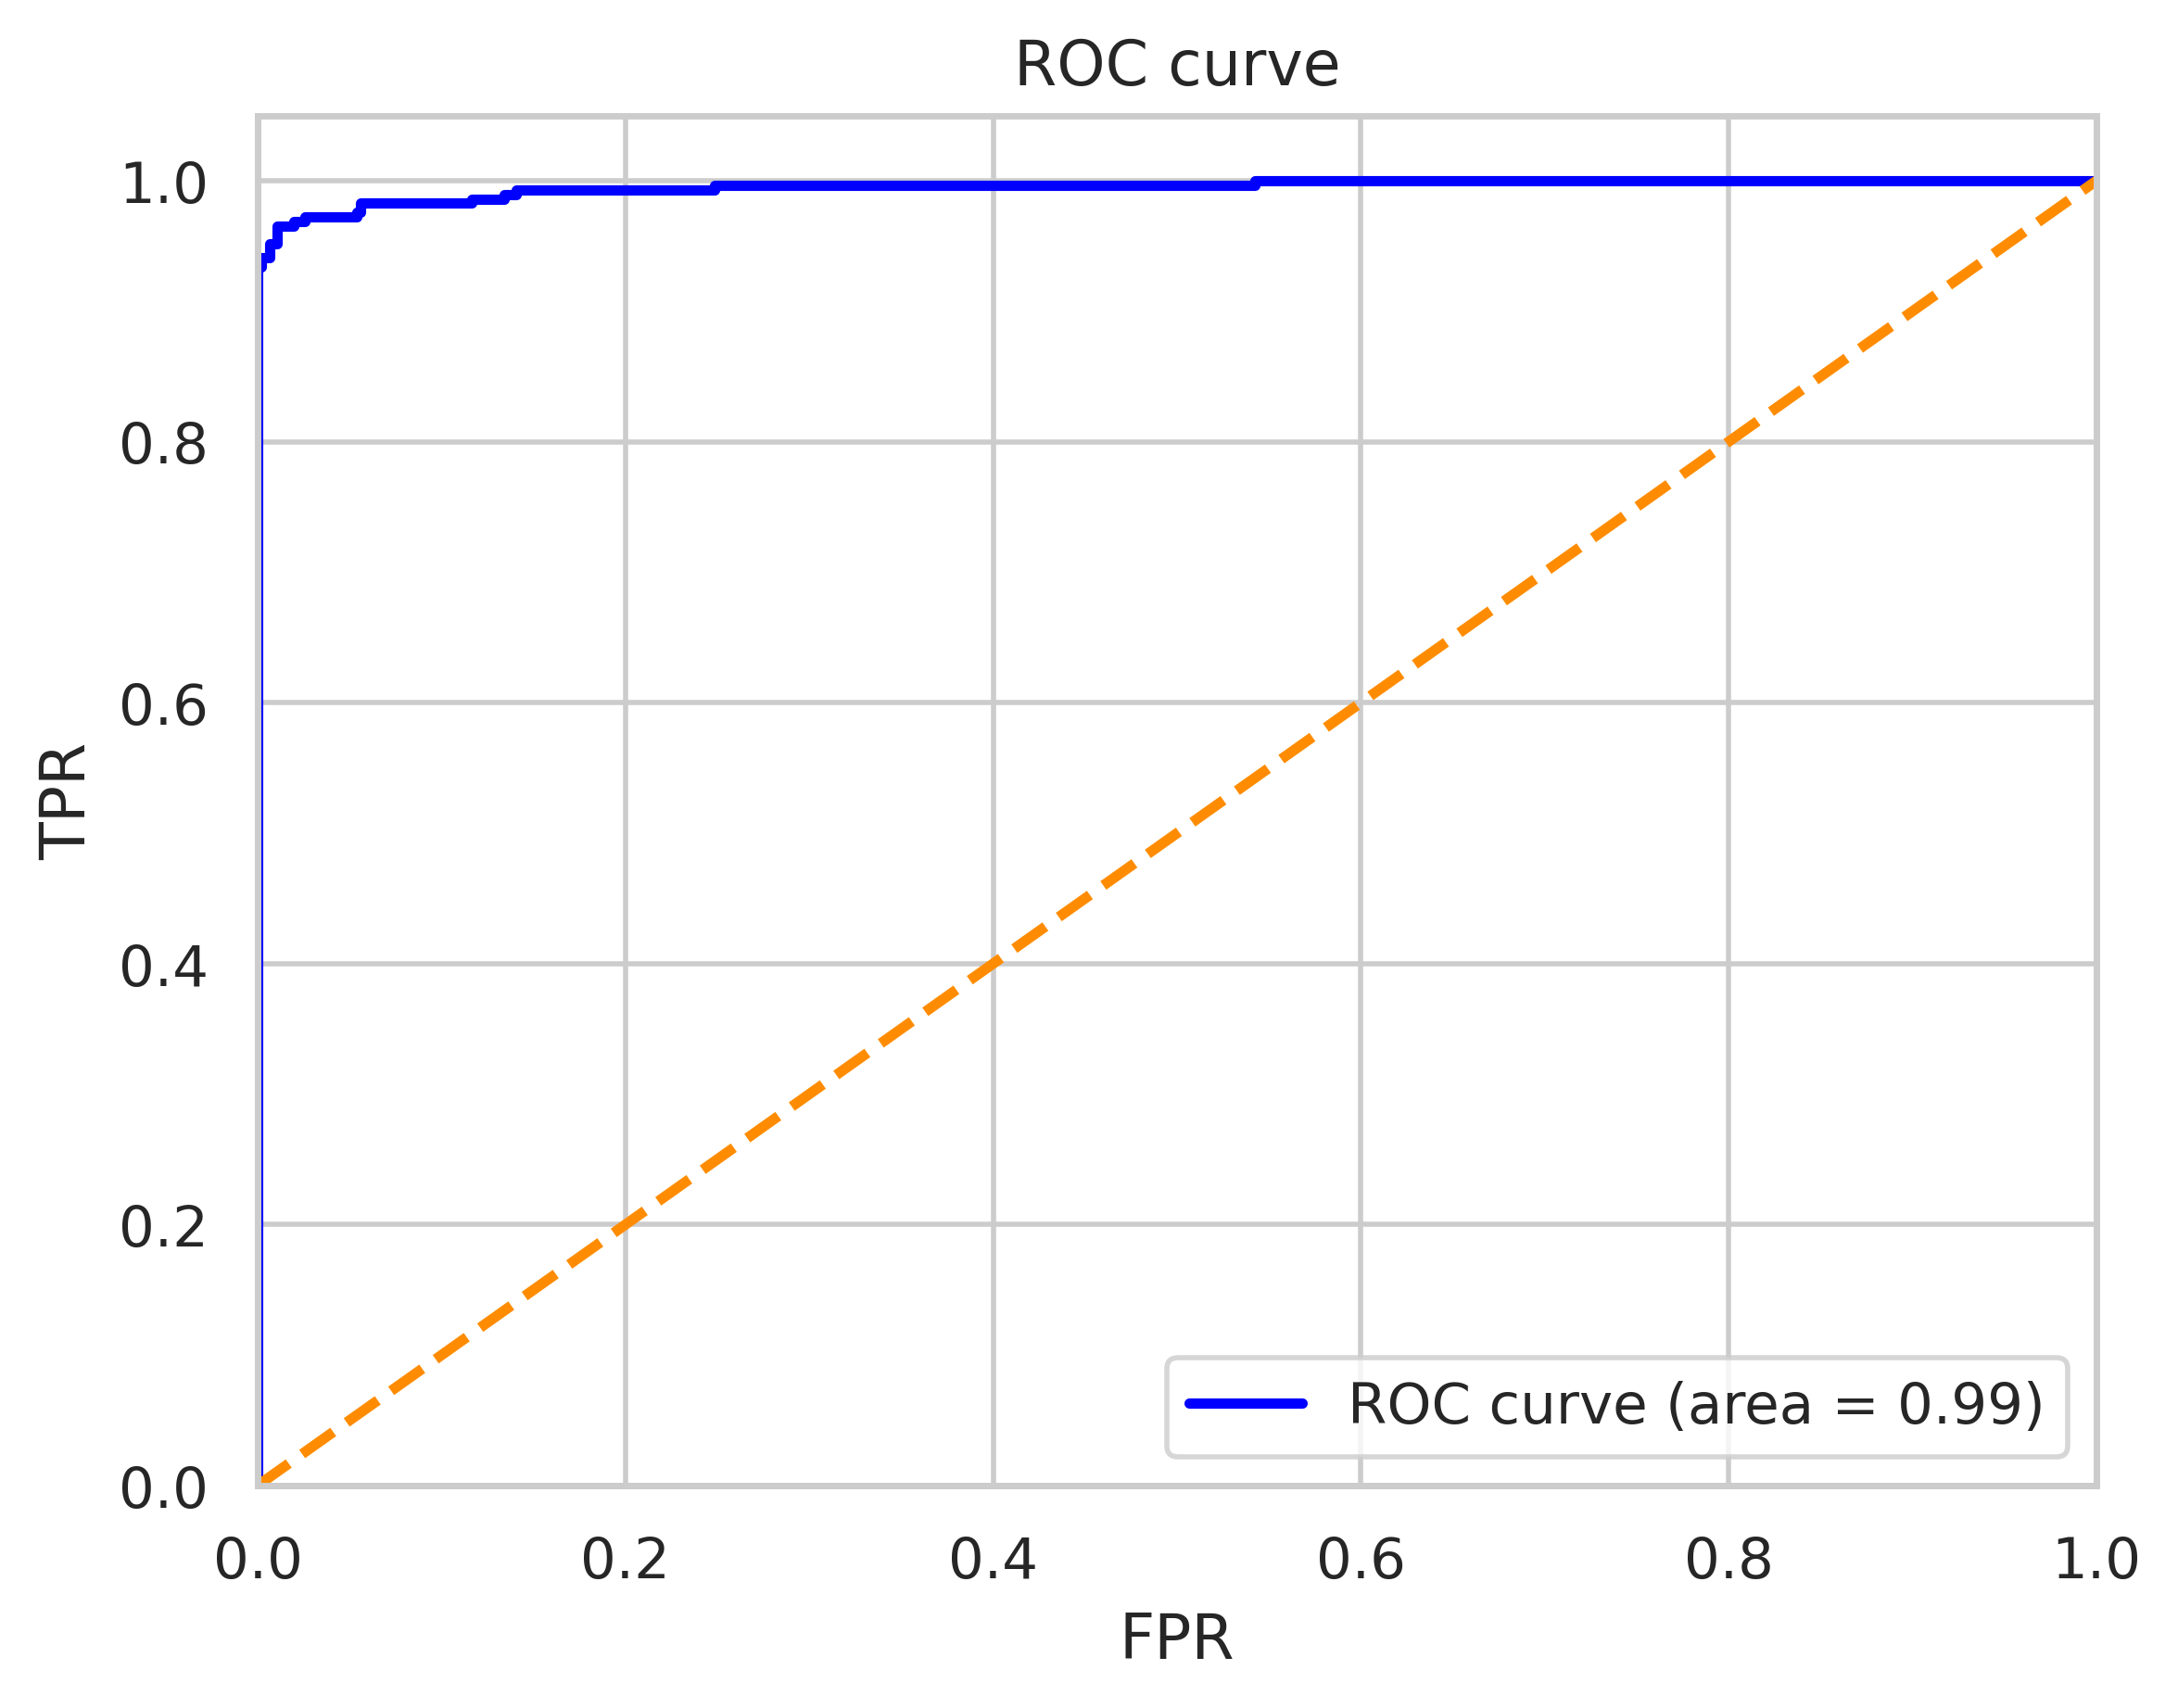

In [9]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
# Assuming 'test_y' are the true labels and 'probabilities' are the probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_prob)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(dpi=400)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='darkorange', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.savefig("morph_roc.png")

In [10]:
import torch.quantization
import torch.nn.utils.prune as prune

module1 = model.fc1
module2 = model.fc2
module3 = model.conv1
module4 = model.conv2

prune.ln_structured(module1, name='weight', amount=0.25, n=2, dim=0)
prune.ln_structured(module2, name='weight', amount=0.25, n=2, dim=0)

prune.ln_structured(module3, name='weight', amount=0.25, n=2, dim=0)
prune.ln_structured(module4, name='weight', amount=0.25, n=2, dim=0)

prune.remove(module1, 'weight')
prune.remove(module2, 'weight')
prune.remove(module3, 'weight')
prune.remove(module4, 'weight')

# Quantize only the weights
model_q = torch.quantization.quantize_dynamic(
    model,  # the original model
    {torch.nn.Linear},  # specify which layer types to quantize
    dtype=torch.qint8  # specify the data type for quantization
)

torch.save(model_q.state_dict(), 'model_quantized.pth')


Accuracy: 0.9787
[[458   5]
 [ 11 277]]
Precision: 0.9892008639308856
Recall: 0.976545842217484
f1: 0.9828326180257511


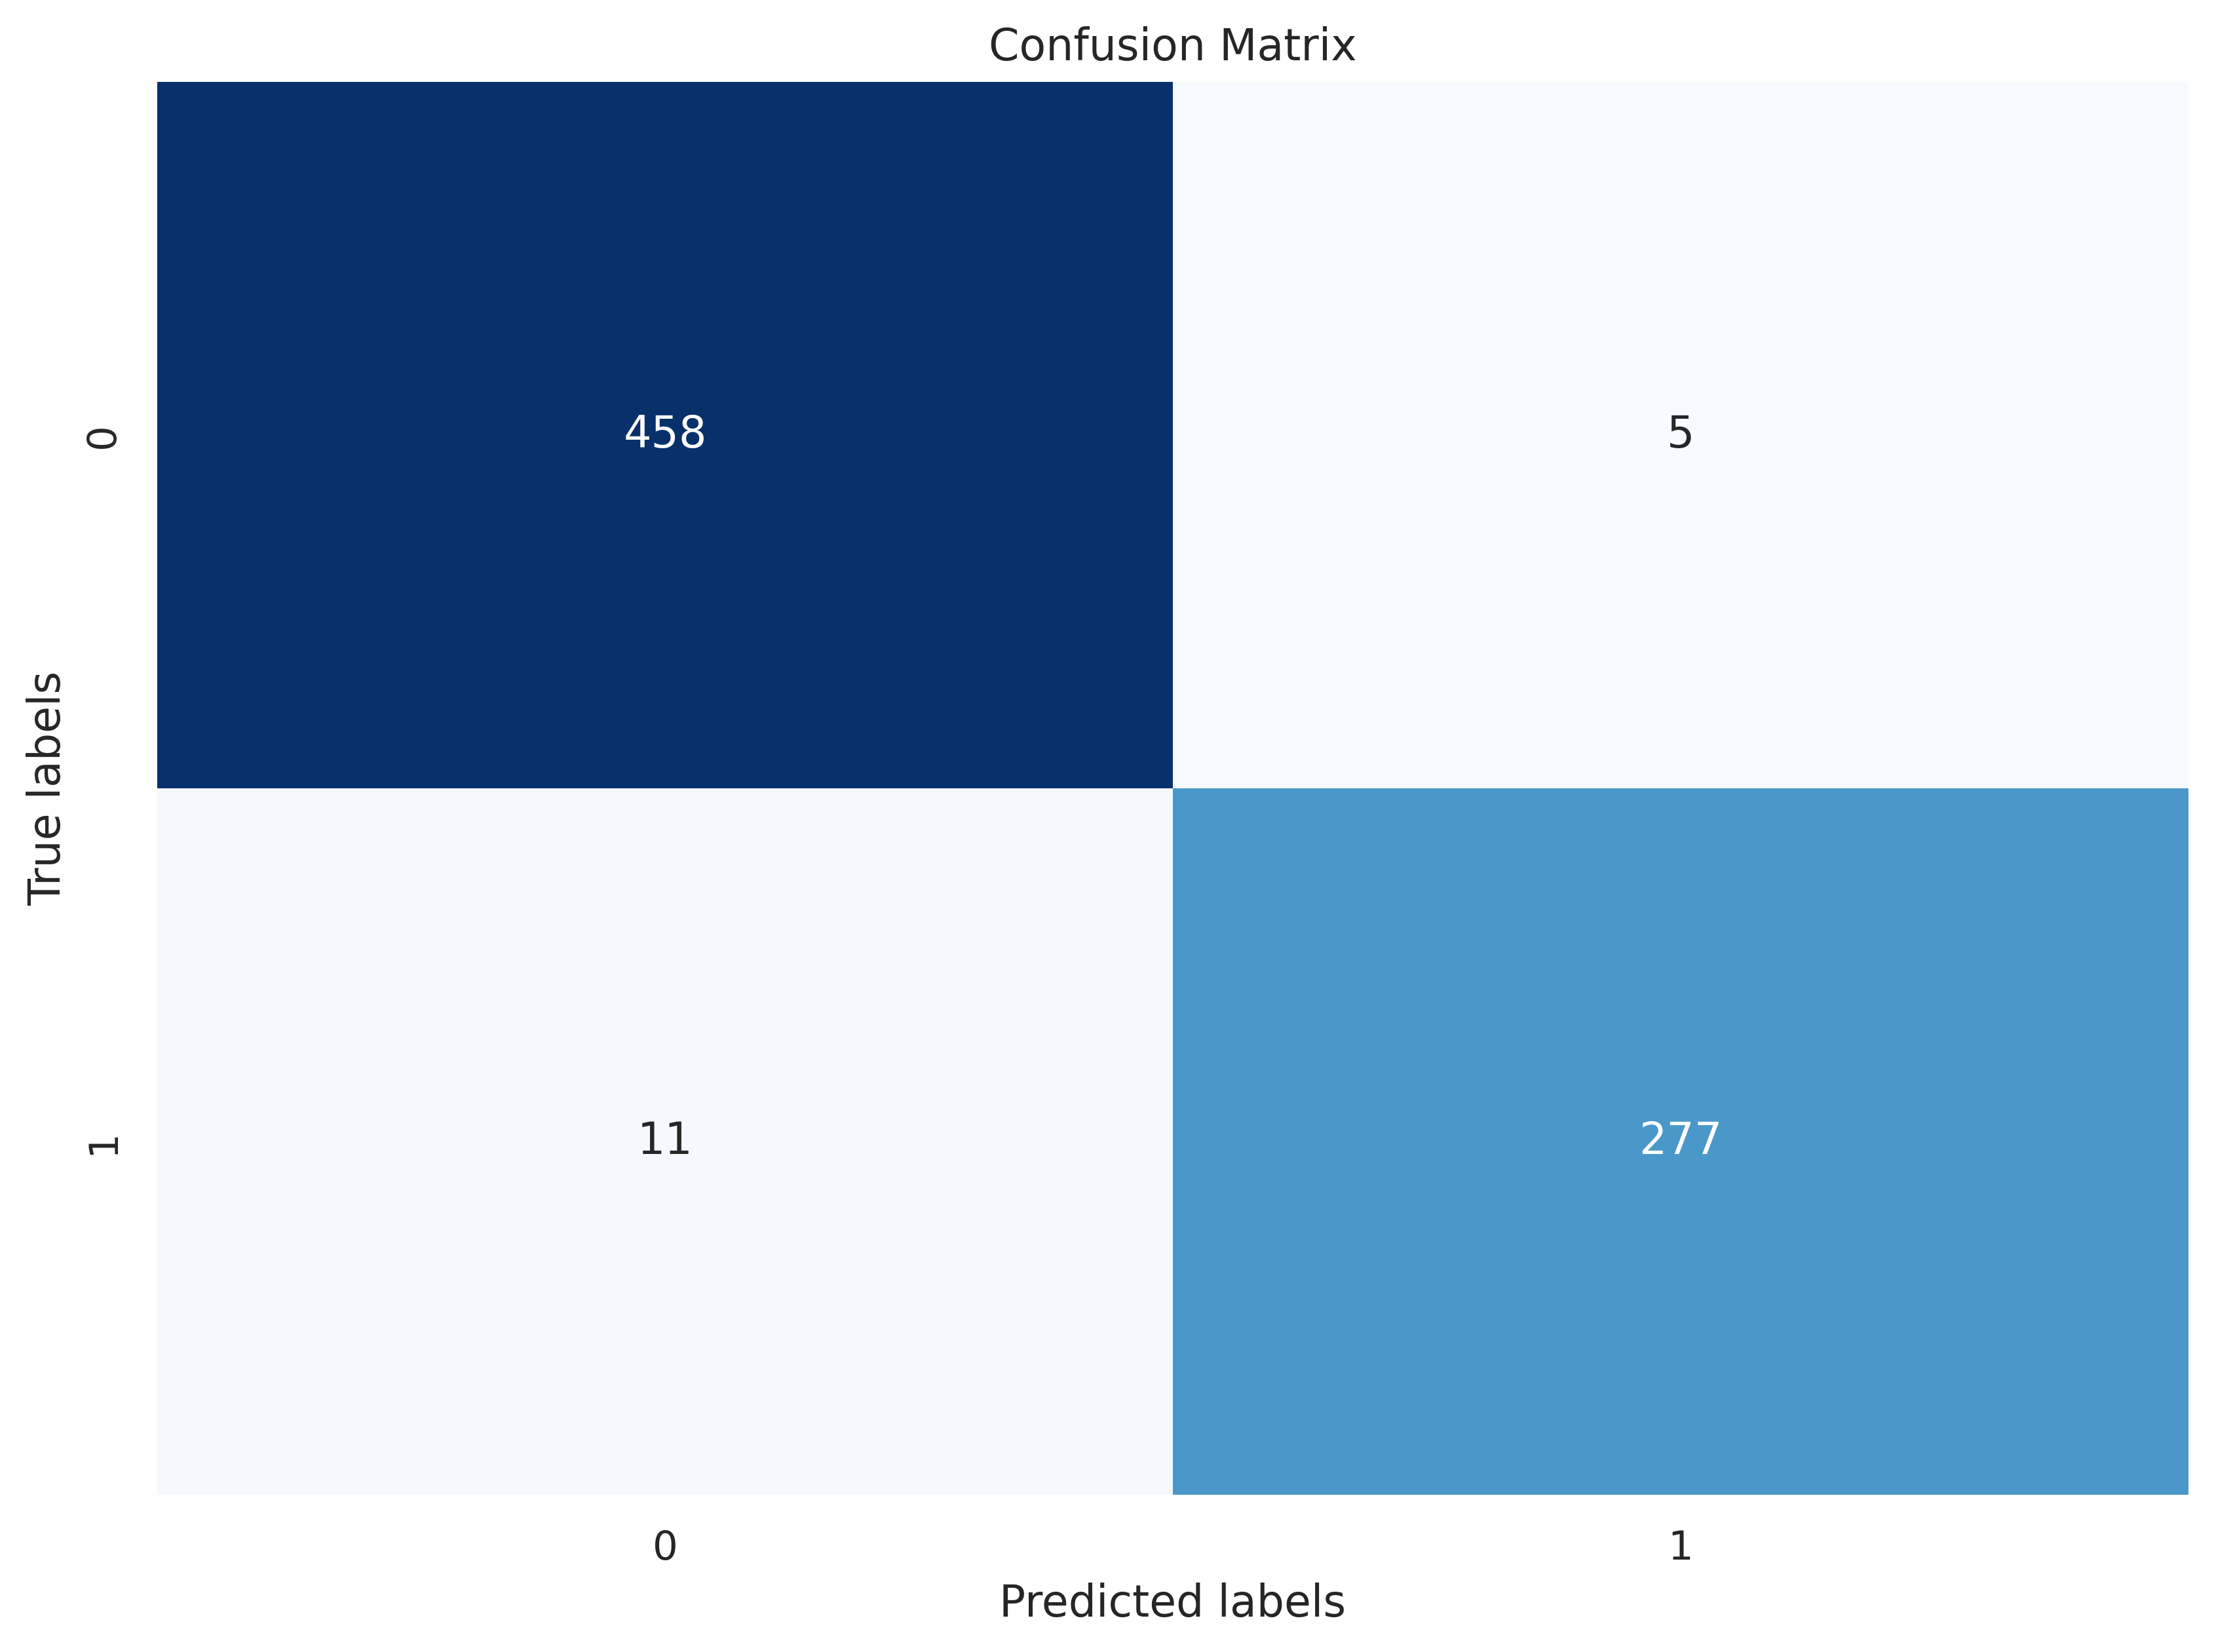

In [11]:
with torch.no_grad():
    # Predict on testing data
    y_pred_test = model_q.forward(X_test_mod)
    #print(y_pred_test)

    y_pred_test_prob = torch.sigmoid(y_pred_test)
    

    y_pred_test_binary = (y_pred_test_prob > 0.5).float()
    
    # Calculate the accuracy
    correct_predictions = (y_pred_test_binary == y_test).float().sum()
    accuracy = correct_predictions / y_test.shape[0]
    
    print(f'Accuracy: {accuracy.item():.4f}')

    y_pred_test_np = y_pred_test_binary.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    
    # Generate the confusion matrix
    cm = confusion_matrix(y_test_np, y_pred_test_np)
    print(cm)
    precision = cm[0, 0] / (cm[0, 0] + cm[0,1])
    recall = cm[0, 0] / (cm[0, 0] + cm[1,0])
    f1 = 2 * (precision * recall)/(precision + recall)
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"f1: {f1}")
    plt.figure(figsize=(10,7), dpi=400)  # You can adjust the size as needed
    sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", cbar=False)  # 'g' means generic number format
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    #plt.savefig('morph_cf.png')
    plt.show()
        